<a href="https://colab.research.google.com/github/danaderp/SecureReqNet/blob/master/alpha_securereqnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Alpha-SecureReqNet

In [1]:
#danaderp May6'19
#Prediction For Main Issues Data Set 
#alpha-SecureReqNet

In [2]:
import csv
from tensorflow.keras.preprocessing import text
from nltk.corpus import gutenberg
from string import punctuation
from tensorflow.keras.preprocessing.sequence import skipgrams

import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

from nltk.stem.snowball import SnowballStemmer
englishStemmer=SnowballStemmer("english")

In [3]:
import re, nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn import metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/thutran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/thutran/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/thutran/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
#Importing Neural Dependencies
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dot, Input, Dense, Reshape, LSTM, Conv2D, Flatten, MaxPooling1D, Dropout, MaxPooling2D
from tensorflow.keras.layers import Embedding, Multiply, Subtract
from tensorflow.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
print(tf.__version__)

2.1.0


In [5]:
#Visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE

Using TensorFlow backend.


In [6]:
import io, os, sys, types

from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import roc_curve, accuracy_score, precision_score, recall_score, roc_auc_score

from sklearn.metrics import f1_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPClassifier

In [11]:
from data.read_data import Dynamic_Dataset
from data.read_data import Processing_Dataset

### Loading word embeddings from previous compression

In [12]:
path = "data/augmented_dataset/" #Place here the dataset you want to process
process_unit = Processing_Dataset(path)
ground_truth = process_unit.get_ground_truth()

In [13]:
dataset = Dynamic_Dataset(ground_truth, path)
test, train = process_unit.get_test_and_training(ground_truth)
print(len(test),len(train))
print(test[0],train[0])

11612 104510
('(1,0)', 'An issue was discovered in app/Controller/UsersController.php in MISP 2.4.92. An adversary can bypass the brute-force protection by using a PUT HTTP method instead of a POST HTTP method in the login part, because this protection was only covering POST requests.') ('(1,0)', 'The currently used Rails version, in the stable branch, is insecure\n\nYou should update the Gemfile.lock to hotfix this.\n\nhttp://weblog.rubyonrails.org/2014/2/18/Rails_3_2_17_4_0_3_and_4_1_0_beta2_have_been_released/')


In [14]:
#Preprocesing Corpora
# Takes around 5 mins to finish
max_words = 5000 #<------- [Parameter]
pre_corpora_train = [doc for doc in train if len(doc[1])< max_words]
pre_corpora_test = [doc for doc in test if len(doc[1])< max_words]

In [15]:
import pandas as pd
embed_path = 'data/word_embeddings-embed_size_100-epochs_100.csv'
df = pd.read_csv(embed_path)
cols = df.columns[1:]

print(len(cols))
print(cols)
df.reset_index()
embeddings_dict = {}
for i in range(len(cols)):
    embeddings_dict[cols[i]] = list(df.iloc[:,i+1])


17227
Index(['use', 'user', 'version', 'test', 'file', 'secur', 'vulner', 'issu',
       'allow', 'new',
       ...
       'enfield', 'hvidovr', 'madura', 'nonotak', 'bazeley', 'kunnam',
       'steelesvill', 'pessoa', 'morisada', 'kuttin'],
      dtype='object', length=17227)


In [16]:
corpora_train_mod = []

y_train=[]
for row in pre_corpora_train:
    corpora_train_mod.append(row[1])
    y_train.append(row[0][1])
    
np.asarray(y_train)
corpora_test_mod=[]
y_test=[]
for row in pre_corpora_test:
    corpora_test_mod.append(row[1])
    y_test.append(row[0][1])
    
np.asarray(y_test)

array(['1', '0', '1', ..., '0', '1', '0'], dtype='<U1')

In [17]:
# Take 5 mins to finish
num_features = 100

def nomalizer(sent):
    only_letters=re.sub("[^a-zA-Z]", " ", sent)
    tokens=nltk.word_tokenize(only_letters)[2:]
    lower_case=[l.lower() for l in tokens]
    stop_words = set(stopwords.words('english'))
    wordnet_lemmatizer=WordNetLemmatizer()
    filtered_result=list(filter(lambda l: l not in stop_words, lower_case))
    lemmas=[wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

# Generate a sentence vector by averaging words embeddings in a sentence
def generate_sentence_vec(sentence, embeddings_dict, num_features):
    sentence_vec=np.zeros(num_features,dtype="float32")
    num_words = 0
    
    embeddings_set=set(embeddings_dict.keys())
    
    for word in sentence:
        if word in embeddings_set:
            num_words+=1
            sentence_vec=np.add(sentence_vec, embeddings_dict[word])
    
    sentence_vec=np.divide(sentence_vec,num_words)
    #print(sentence_vec)
    return sentence_vec

# Generate all senteneces vectors
def generate_average_sentences_vec(sentences,embeddings_dict,num_features):
    count=0
    total_sent=len(sentences)
    sentences_vec=np.zeros((len(sentences),num_features),dtype="float32")
    
    for sentence in sentences:
        if count % 1000 == 0:
            print("Sentences {} of {}".format(count,total_sent))

        sentences_vec[count] = generate_sentence_vec(sentence, embeddings_dict, num_features)
        count+=1

    return sentences_vec

def get_sentence_vectors(raw_data):
    data = []
    print(len(raw_data))
    print("---- Nomalizing ----")
    for sent in raw_data:
        data.append(nomalizer(sent))
    
    print(len(data))
    X=generate_average_sentences_vec(data, embeddings_dict, num_features)
    return X

X_train_data = get_sentence_vectors(corpora_train_mod)
X_test_data=get_sentence_vectors(corpora_test_mod)

103867
---- Nomalizing ----
103867
Sentences 0 of 103867


/home/thutran/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


Sentences 1000 of 103867
Sentences 2000 of 103867
Sentences 3000 of 103867
Sentences 4000 of 103867
Sentences 5000 of 103867
Sentences 6000 of 103867
Sentences 7000 of 103867
Sentences 8000 of 103867
Sentences 9000 of 103867
Sentences 10000 of 103867
Sentences 11000 of 103867
Sentences 12000 of 103867
Sentences 13000 of 103867
Sentences 14000 of 103867
Sentences 15000 of 103867
Sentences 16000 of 103867
Sentences 17000 of 103867
Sentences 18000 of 103867
Sentences 19000 of 103867
Sentences 20000 of 103867
Sentences 21000 of 103867
Sentences 22000 of 103867
Sentences 23000 of 103867
Sentences 24000 of 103867
Sentences 25000 of 103867
Sentences 26000 of 103867
Sentences 27000 of 103867
Sentences 28000 of 103867
Sentences 29000 of 103867
Sentences 30000 of 103867
Sentences 31000 of 103867
Sentences 32000 of 103867
Sentences 33000 of 103867
Sentences 34000 of 103867
Sentences 35000 of 103867
Sentences 36000 of 103867
Sentences 37000 of 103867
Sentences 38000 of 103867
Sentences 39000 of 10

In [18]:
# corpora_train = X_train_data
# corpora_test = X_test_data

In [112]:
# X_train_data = corpora_train
# X_test_data = corpora_test

In [113]:
X_train_data=SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(corpora_train)
X_test_data=SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(corpora_test)

In [114]:
# Standardizing the features
X_train_data = StandardScaler().fit_transform(X_train_data)
X_test_data = StandardScaler().fit_transform(X_test_data)

In [108]:
corpora_train.shape

(103867, 100)

In [109]:
X_train_data.shape

(103867, 100)

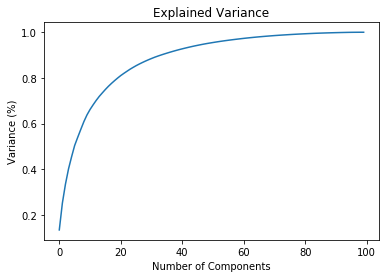

In [82]:
#Plotting the Cumulative Summation of the Explained Variance
pca = PCA().fit(X_train_data)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

In [110]:
# pca = PCA(n_components=80)
# X_train_data = pca.fit_transform(X_train_data)
# X_test_data = pca.fit_transform(X_test_data)

In [25]:
features_selected=[25, 15, 55, 51, 86, 29, 62, 69, 95, 32, 44, 68, 89, 0, 2, 5, 9, 10, 11, 12, 13, 18, 21, 28, 34, 35, 42, 49, 54, 57, 60, 63, 66, 67, 74, 77, 79, 83, 85, 91, 97, 1, 3, 4, 6, 7, 8, 14, 16, 17, 19, 20, 22, 23, 24, 26, 27, 30, 31, 33, 36, 37, 38, 39, 40, 41, 43, 45, 46, 47, 48, 50, 52, 53, 56, 58, 59, 61, 64, 65, 70, 71, 72, 73, 75, 76, 78, 80, 81, 82, 84, 87, 88, 90, 92, 93, 94, 96, 98, 99]

In [84]:
# def concatenate(t1, t2):
#     return np.concatenate((t1, t2), axis=1)

In [85]:
# poly = PolynomialFeatures(interaction_only=True)
# k = 10
# cross_train_features = X_train_data[:, features_selected[:k]]
# cross_train_features = poly.fit_transform(cross_train_features)
# X_train_data = concatenate(X_train_data[:, features_selected[k:]], cross_train_features)
# #
# cross_test_features = X_test_data[:, features_selected[:k]]
# cross_test_features = poly.fit_transform(cross_test_features)
# X_test_data = concatenate(X_test_data[:, features_selected[k:]], cross_test_features)


In [119]:
import time
start_time = time.time()
y_pred_rf=np.zeros(shape=(len(y_test),1))
y_pred_svc=np.zeros(shape=(len(y_test),1))
y_pred_nb=np.zeros(shape=(len(y_test),1))

def train_clf(name, clf, y_pred, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    
    acc=accuracy_score(y_test, y_pred) 

    y_pred_proba = clf.predict_proba(x_test)
    auc=roc_auc_score(y_test, y_pred_proba[:,1])

    
    print("{} accuracy is {}".format(name, acc))
    print("{} AUC is {}".format(name, auc))
    return clf
    
# rf_clf = train_clf('Random_Forest', RandomForestClassifier(), y_pred_rf,X_train_data,y_train,X_test_data,y_test)
# rf_clf = train_clf('Random_Forest', RandomForestClassifier(n_estimators=5, random_state=100, max_depth=8), y_pred_rf,X_train_data[:, features_selected[:50]],y_train,X_test_data[:, features_selected[:50]],y_test)
# lr_clf = train_clf('Logistic Regression', LogisticRegression(), y_pred_rf, X_train_data,y_train,X_test_data,y_test)

# train_clf('Gradient Boosting Trees', GradientBoostingClassifier(), y_pred_rf,X_train_data,y_train,X_test_data,y_test)
# SVM 2-3 hours
# train_clf('SVC',SVC(gamma='auto',probability=True), y_pred_svc,X_train_data,y_train,X_test_data,y_test)
# train_clf('Naive bayes',GaussianNB(), y_pred_nb,X_train_data,y_train,X_test_data,y_test)

mlp_clf = train_clf('MLP', MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 100), random_state=1), y_pred_rf,X_train_data,y_train,X_test_data,y_test)
print("--- %s seconds ---" % (time.time() - start_time))

MLP accuracy is 0.9330620020782819
MLP AUC is 0.9763749151995136
--- 131.54987406730652 seconds ---


/home/thutran/anaconda3/envs/python3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [184]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [186]:
rfc = RandomForestClassifier()
parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32,None]   
}
from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(rfc,parameters,cv=5)
cv.fit(X_train_data,y_train)
display(cv)


KeyboardInterrupt: 

In [122]:
feature_list = list(range(0, 101))

In [160]:
# Get numerical feature importances
importances = list(rf_clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
# [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]
features_selected = []
for pair in feature_importances:
#     if pair[1] > 0:
    features_selected.append(pair[0])
print(features_selected)

[25, 15, 55, 51, 86, 29, 62, 69, 95, 32, 44, 68, 89, 0, 2, 5, 9, 10, 11, 12, 13, 18, 21, 28, 34, 35, 42, 49, 54, 57, 60, 63, 66, 67, 74, 77, 79, 83, 85, 91, 97, 1, 3, 4, 6, 7, 8, 14, 16, 17, 19, 20, 22, 23, 24, 26, 27, 30, 31, 33, 36, 37, 38, 39, 40, 41, 43, 45, 46, 47, 48, 50, 52, 53, 56, 58, 59, 61, 64, 65, 70, 71, 72, 73, 75, 76, 78, 80, 81, 82, 84, 87, 88, 90, 92, 93, 94, 96, 98, 99]


In [161]:
feature_importances

[(25, 0.13),
 (15, 0.1),
 (55, 0.05),
 (51, 0.04),
 (86, 0.04),
 (29, 0.03),
 (62, 0.03),
 (69, 0.03),
 (95, 0.03),
 (32, 0.02),
 (44, 0.02),
 (68, 0.02),
 (89, 0.02),
 (0, 0.01),
 (2, 0.01),
 (5, 0.01),
 (9, 0.01),
 (10, 0.01),
 (11, 0.01),
 (12, 0.01),
 (13, 0.01),
 (18, 0.01),
 (21, 0.01),
 (28, 0.01),
 (34, 0.01),
 (35, 0.01),
 (42, 0.01),
 (49, 0.01),
 (54, 0.01),
 (57, 0.01),
 (60, 0.01),
 (63, 0.01),
 (66, 0.01),
 (67, 0.01),
 (74, 0.01),
 (77, 0.01),
 (79, 0.01),
 (83, 0.01),
 (85, 0.01),
 (91, 0.01),
 (97, 0.01),
 (1, 0.0),
 (3, 0.0),
 (4, 0.0),
 (6, 0.0),
 (7, 0.0),
 (8, 0.0),
 (14, 0.0),
 (16, 0.0),
 (17, 0.0),
 (19, 0.0),
 (20, 0.0),
 (22, 0.0),
 (23, 0.0),
 (24, 0.0),
 (26, 0.0),
 (27, 0.0),
 (30, 0.0),
 (31, 0.0),
 (33, 0.0),
 (36, 0.0),
 (37, 0.0),
 (38, 0.0),
 (39, 0.0),
 (40, 0.0),
 (41, 0.0),
 (43, 0.0),
 (45, 0.0),
 (46, 0.0),
 (47, 0.0),
 (48, 0.0),
 (50, 0.0),
 (52, 0.0),
 (53, 0.0),
 (56, 0.0),
 (58, 0.0),
 (59, 0.0),
 (61, 0.0),
 (64, 0.0),
 (65, 0.0),
 (70, 0.0)

In [136]:
X_train_data[:, features_selected]

array([[ 0.7252351 , -0.4644001 ,  0.73004574, ..., -0.0562367 ,
         0.41373098, -0.02861318],
       [-0.32241738, -0.23658918,  0.16026123, ..., -0.29877725,
        -0.09687816, -0.49743745],
       [-0.07247504, -0.46248347,  0.79734564, ...,  0.3695743 ,
        -0.7581393 , -0.5827062 ],
       ...,
       [-1.6678915 ,  0.7265794 , -0.7388001 , ...,  0.19107978,
        -0.32040438,  0.8675303 ],
       [-0.14691226,  0.35449713, -0.38287878, ..., -0.08266836,
         0.11690775, -0.08137528],
       [-0.4779806 ,  0.14514089, -0.7929699 , ...,  0.18740511,
         0.34701014,  0.00256654]], dtype=float32)

In [ ]:
target_train = [[int(list(doc[0])[1]),int(list(doc[0])[3])] for doc in pre_corpora_train]#vectorization Output
target_test = [[int(list(doc[0])[1]),int(list(doc[0])[3])]for doc in pre_corpora_test]#vectorization Output

In [ ]:
max_len_sentences_train = max([len(doc) for doc in corpora_train]) #<------- [Parameter]
max_len_sentences_test = max([len(doc) for doc in corpora_test]) #<------- [Parameter]

In [ ]:
max_len_sentences = max(max_len_sentences_train,max_len_sentences_test)
print("Max. Sentence # words:",max_len_sentences)

In [ ]:
min_len_sentences_train = min([len(doc) for doc in corpora_train]) #<------- [Parameter]
min_len_sentences_test = min([len(doc) for doc in corpora_test]) #<------- [Parameter]

In [242]:
min_len_sentences = max(min_len_sentences_train,min_len_sentences_test)
print("Min. Sentence # words:",min_len_sentences)

Min. Sentence # words: 100


In [ ]:
embed_size = np.size(corpora_train[0][0])

### Designing Baseline Architecture

In [244]:
#BaseLine Architecture <-------
embeddigs_cols = embed_size
input_sh = (max_len_sentences,embeddigs_cols,1)
#Selecting filters? 
#https://stackoverflow.com/questions/48243360/how-to-determine-the-filter-parameter-in-the-keras-conv2d-function
#https://stats.stackexchange.com/questions/196646/what-is-the-significance-of-the-number-of-convolution-filters-in-a-convolutional

N_filters = 128 # <-------- [HyperParameter] Powers of 2 Numer of Features
K = 2 # <-------- [HyperParameter] Number of Classess

In [246]:
gram_input = Input(shape = input_sh)
# 1st Convolutional Layer Convolutional Layer (7-gram)
conv_1_layer = Conv2D(filters=32, input_shape=input_sh, activation='relu', 
                      kernel_size=(7,embeddigs_cols), padding='valid')(gram_input)
conv_1_layer.shape

TensorShape([None, 94, 1, 32])

In [247]:
# Max Pooling 
max_1_pooling = MaxPooling2D(pool_size=((max_len_sentences-7+1),1), strides=None, padding='valid')(conv_1_layer)
max_1_pooling.shape

TensorShape([None, 1, 1, 32])

In [248]:
# Fully Connected layer
fully_connected_1_gram = Flatten()(max_1_pooling)
fully_connected_1_gram.shape

TensorShape([None, 32])

In [249]:
fully_connected_1_gram = Reshape((32, 1, 1))(fully_connected_1_gram)
fully_connected_1_gram.shape

TensorShape([None, 32, 1, 1])

In [250]:
# 2nd Convolutional Layer (5-gram)
conv_2_layer = Conv2D(filters=64, kernel_size=(5,1), activation='relu', 
                      padding='valid')(fully_connected_1_gram)
conv_2_layer.shape

TensorShape([None, 28, 1, 64])

In [251]:
max_2_pooling = MaxPooling2D(pool_size=((32-5+1),1), strides=None, padding='valid')(conv_2_layer)
max_2_pooling.shape

TensorShape([None, 1, 1, 64])

In [252]:
# Fully Connected layer
fully_connected_2_gram = Flatten()(max_2_pooling)
fully_connected_2_gram.shape

TensorShape([None, 64])

In [253]:
fully_connected_2_gram = Reshape((64, 1, 1))(fully_connected_2_gram)
fully_connected_2_gram.shape

TensorShape([None, 64, 1, 1])

In [254]:
# 3rd Convolutional Layer (3-gram)
conv_3_layer =  Conv2D(filters=128, kernel_size=(3,1), activation='relu', 
                      padding='valid')(fully_connected_2_gram)
conv_3_layer.shape

TensorShape([None, 62, 1, 128])

In [255]:
# 4th Convolutional Layer (3-gram)
conv_4_layer = Conv2D(filters=128, kernel_size=(3,1), activation='relu', 
                     padding='valid')(conv_3_layer)
conv_4_layer.shape

TensorShape([None, 60, 1, 128])

In [256]:
# 5th Convolutional Layer (3-gram)
conv_5_layer = Conv2D(filters=64, kernel_size=(3,1), activation='relu', 
                     padding='valid')(conv_4_layer)
conv_5_layer.shape

TensorShape([None, 58, 1, 64])

In [257]:
# Max Pooling
max_5_pooling = MaxPooling2D(pool_size=(58,1), strides=None, padding='valid')(conv_5_layer)
max_5_pooling.shape

TensorShape([None, 1, 1, 64])

In [258]:
# Fully Connected layer
fully_connected = Flatten()(max_5_pooling)
fully_connected.shape

TensorShape([None, 64])

In [259]:
# 1st Fully Connected Layer
deep_dense_1_layer = Dense(32, activation='relu')(fully_connected)
deep_dense_1_layer = Dropout(0.2)(deep_dense_1_layer) # <-------- [HyperParameter]
deep_dense_1_layer.shape

TensorShape([None, 32])

In [260]:
# 2nd Fully Connected Layer
deep_dense_2_layer = Dense(32, activation='relu')(deep_dense_1_layer)
deep_dense_2_layer = Dropout(0.2)(deep_dense_2_layer) # <-------- [HyperParameter]
deep_dense_2_layer.shape

TensorShape([None, 32])

In [261]:
# 3rd Fully Connected Layer
deep_dense_3_layer = Dense(16, activation='relu')(deep_dense_2_layer)
deep_dense_3_layer = Dropout(0.2)(deep_dense_3_layer) # <-------- [HyperParameter]
deep_dense_3_layer.shape

TensorShape([None, 16])

In [385]:
predictions = Dense(K, activation='softmax')(deep_dense_3_layer)
#Criticality Model
criticality_network = Model(inputs=[gram_input],outputs=[predictions]) 

In [386]:
print(criticality_network.summary())

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 1, 1)]       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 94, 1, 32)         256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 32)                0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 32, 1, 1)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 1, 64)         384       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 1, 64)          0   

In [388]:
#Seting up the Model
criticality_network.compile(optimizer='adam',loss='binary_crossentropy',
                                  metrics=['accuracy'])

### Training the criticality network

In [360]:
#Data set organization
from tempfile import mkdtemp
import os.path as path

In [ ]:
#Memoization 
file_corpora_train_x = path.join(mkdtemp(), 'train_x.dat') #Update per experiment
file_corpora_test_x = path.join(mkdtemp(), 'test_x.dat')

In [362]:
#Memoization 
file_corpora_train_x = path.join(mkdtemp(), 'train_x.dat') #Update per experiment
file_corpora_test_x = path.join(mkdtemp(), 'test_x.dat')

In [363]:
#Shaping
shape_train_x = (len(corpora_train),max_len_sentences,embeddigs_cols,1)
shape_test_x = (len(corpora_test),max_len_sentences,embeddigs_cols,1)

In [364]:
#Data sets
corpora_train_x = np.memmap(
        filename = file_corpora_train_x, 
        dtype='float32', 
        mode='w+', 
        shape = shape_train_x)

In [365]:
corpora_test_x = np.memmap( #Test Corpora (for future evaluation)
        filename = file_corpora_test_x, 
        dtype='float32', 
        mode='w+', 
        shape = shape_test_x)

In [366]:
target_train_y = np.array(target_train) #Train Target
target_test_y = np.array(target_test) #Test Target (for future evaluation)

In [369]:
#Reshaping Train Inputs
for doc in range(len(corpora_train)):
    #print(corpora_train[doc].shape[1])
    for words_rows in range(corpora_train[doc].shape[0]):
        embed_flatten = np.array(corpora_train[doc][words_rows]).flatten() #<--- Capture doc and word
        for embedding_cols in range(embed_flatten.shape[0]):
            corpora_train_x[doc,words_rows,embedding_cols,0] = embed_flatten[embedding_cols]

In [370]:
#Reshaping Test Inputs (for future evaluation)
for doc in range(len(corpora_test)):
    for words_rows in range(corpora_test[doc].shape[0]):
        embed_flatten = np.array(corpora_test[doc][words_rows]).flatten() #<--- Capture doc and word
        for embedding_cols in range(embed_flatten.shape[0]):
            corpora_test_x[doc,words_rows,embedding_cols,0] = embed_flatten[embedding_cols]

In [371]:
#CheckPoints
filepath = "best_model.hdf5"

In [372]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint(filepath, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
callbacks_list = [es,mc]

In [ ]:
length = len(corpora_train_x)
mask = np.random.choice(length, length, replace=False)
# Use the same mask to maintain the shuffling sequence between data and labels
shuffled_data = corpora_train_x[mask]
shuffled_labels = target_train_y[mask]


In [ ]:
#Model Fitting
history = criticality_network.fit(
            x = shuffled_data, 
            y = shuffled_labels,
            batch_size=64,
            epochs=40, #5 <------ Hyperparameter
            validation_split = 0.2,
            callbacks=callbacks_list,
            shuffle=True
)

In [ ]:
count_1 = 0
count_2 = 0
for i in target_train_y:
    if i[0] == 1:
        count_1 +=1 
    else:
        count_2 +=1
print('{}, {}'.format(count_1, count_2))

In [ ]:
#Saving Training History
df_history = pd.DataFrame.from_dict(history.history)
df_history.to_csv('history_training.csv', encoding='utf-8',index=False)

In [403]:
criticality_network.save(filepath)
df_history.head()

,loss,accuracy,val_loss,val_accuracy
0,0.693379,0.499856,0.693123,0.504933
1,0.693190,0.501420,0.693196,0.495067


In [404]:
#Saving Test Data
np.save('corpora_test_x.npy',corpora_test_x)
np.save('target_test_y.npy',target_test_y)

### Partial Evaluation
To make a deep evaluation, please refer to the "evaluation" notebook.

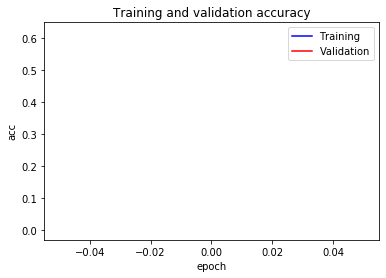

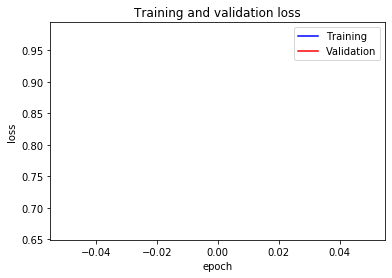

In [380]:
#Evaluation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs2 = range(len(acc))
 
plt.plot(epochs2, acc, 'b', label='Training')
plt.plot(epochs2, val_acc, 'r', label='Validation')
plt.title('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend()
 
plt.figure()
 
plt.plot(epochs2, loss, 'b', label='Training')
plt.plot(epochs2, val_loss, 'r', label='Validation')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
 
plt.show()